In [1]:
!nvidia-smi

Sun Mar  5 10:43:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN RTX   WDDM  | 00000000:01:00.0  On |                  N/A |
| 40%   34C    P8    24W / 280W |    524MiB / 24576MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys
sys.path.append('../')

In [3]:
import os
import sys
import json
import time
import rich
import numpy as np
import pickle
import wandb
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from configs.finetune import FinetuneConfig
from tasks.classification import Classification

from models.backbone.base import calculate_out_features
from models.backbone.densenet import DenseNetBackbone
from models.backbone.resnet import build_resnet_backbone
from models.head.projector import MLPHead
from models.head.classifier import LinearClassifier

from datasets.brain import BrainProcessor, Brain, BrainMoCo
from datasets.transforms import make_transforms, compute_statistics

from utils.logging import get_rich_logger
from utils.gpu import set_gpu

from easydict import EasyDict as edict
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
from matplotlib import colors

from skimage.transform import resize

In [4]:
gpus = ['3']
server = 'dgx'

hashs =[("2022-07-02_08-00-31", "2022-07-03_13-41-32"),
        ("2022-07-02_08-00-57", "2022-07-03_13-37-29"),
        ("2022-07-02_09-38-52", "2022-07-03_13-33-23"),
        ("2022-07-02_09-40-42", "2022-07-03_13-29-10"),
        ("2022-07-02_11-17-38", "2022-07-03_13-25-05"),
        ("2022-07-02_11-20-21", "2022-07-03_13-21-00"),
        ("2022-07-02_17-15-14", "2022-07-03_13-16-54"),
        ("2022-07-02_17-15-34", "2022-07-03_13-12-44"),
        ("2022-07-02_18-53-46", "2022-07-03_13-08-35"),
        ("2022-07-02_18-54-27", "2022-07-03_13-04-32")]

In [5]:
hash = hashs[0]

In [6]:
config = edict()
config.server = server
config.gpus = gpus
local_rank = 0

config.finetune_file = os.path.join(f'../checkpoints/pet-supmoco/resnet/{hash[0]}/ckpt.last.pth.tar')
finetune_config = os.path.join(f'../checkpoints/pet-supmoco/resnet/{hash[0]}/configs.json')
with open(finetune_config, 'rb') as fb:
    finetune_config = json.load(fb)

finetune_config_names = [
    # data_parser
    'data_type', 'root', 'data_info', 'mci_only', 'n_splits', 'n_cv',
    'image_size', 'small_kernel', 'random_state',
    'intensity', 'crop', 'crop_size', 'rotate', 'flip', 'affine', 'blur', 'blur_std', 'prob',
    # model_parser
    'backbone_type', 'init_features', 'growth_rate', 'block_config', 'bn_size', 'dropout_rate',
    'arch', 'no_max_pool',
    # train
    'batch_size',
    # moco / supmoco
    'alphas',
    # others
    'task', 'projector_dim'
]

for name in finetune_config_names:
    if name in finetune_config.keys():
        setattr(config, name, finetune_config[name])

In [7]:
print(config.random_state)

2021


In [8]:
set_gpu(config)
np.random.seed(config.random_state)
torch.manual_seed(config.random_state)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.allow_tf32 = True
torch.cuda.set_device(local_rank)

# Networks
if config.backbone_type == 'densenet':
    backbone = DenseNetBackbone(in_channels=1,
                                init_features=config.init_features,
                                growth_rate=config.growth_rate,
                                block_config=config.block_config,
                                bn_size=config.bn_size,
                                dropout_rate=config.dropout_rate,
                                semi=False)
    activation = True
elif config.backbone_type == 'resnet':
    backbone = build_resnet_backbone(arch=config.arch,
                                     no_max_pool=config.no_max_pool,
                                     in_channels=1,
                                     semi=False)
    activation = False
else:
    raise NotImplementedError

if config.small_kernel:
    backbone._fix_first_conv()

if config.crop:
    out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.crop_size)
else:
    out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.image_size)
projector = MLPHead(out_dim, config.projector_dim)

backbone.load_weights_from_checkpoint(path=config.finetune_file, key='backbone')
projector.load_weights_from_checkpoint(path=config.finetune_file, key='head')

# load finetune data
data_processor = BrainProcessor(root=config.root,
                                data_info=config.data_info,
                                data_type=config.data_type,
                                mci_only=config.mci_only,
                                random_state=config.random_state)
datasets = data_processor.process(n_splits=config.n_splits, n_cv=config.n_cv)

# intensity normalization
assert config.intensity in [None, 'scale', 'minmax']
mean_std, min_max = (None, None), (None, None)
if config.intensity is None:
    pass
elif config.intensity == 'scale':
    pass
elif config.intensity == 'minmax':
    with open(os.path.join(config.root, 'labels/minmax.pkl'), 'rb') as fb:
        minmax_stats = pickle.load(fb)
        min_max = (minmax_stats[config.data_type]['min'], minmax_stats[config.data_type]['max'])
else:
    raise NotImplementedError

train_transform, test_transform = make_transforms(image_size=config.image_size,
                                                  intensity=config.intensity,
                                                  min_max=min_max,
                                                  crop_size=config.crop_size,
                                                  rotate=config.rotate,
                                                  flip=config.flip,
                                                  affine=config.affine,
                                                  blur_std=config.blur_std,
                                                  prob=config.prob)

train_set = Brain(dataset=datasets['train'], data_type=config.data_type, transform=test_transform)
test_set = Brain(dataset=datasets['test'], data_type=config.data_type, transform=test_transform)

train_loader = DataLoader(dataset=train_set, batch_size=16, drop_last=False)
test_loader = DataLoader(dataset=test_set, batch_size=16, drop_last=False)

In [9]:
local_rank = 0

In [10]:
import pandas as pd
mc_table = pd.read_excel('/raidWorkspace/mingu/Data/ADNI/labels/AV45_FBP_SUVR.xlsx', sheet_name='list_id_SUVR_RSF')

In [11]:
mri_table = pd.read_csv('/raidWorkspace/mingu/Data/ADNI/labels/MRI_BAI_features.csv')
mri_table_filenames = mri_table['Filename'].str.split('/', expand=True).iloc[:, 1].values

In [12]:
backbone.to(local_rank)
projector.to(local_rank)

backbone.eval()
projector.eval()

train = {
    'h': [],
    'z': [],
    'y': [],
    'demo': [],
    'hippocampus': [],
    'mc': []
}

test = {
    'h': [],
    'z': [],
    'y': [],
    'demo': [],
    'hippocampus': [],
    'mc': []
}

In [13]:
with torch.no_grad():
    
    for mode, dset, loader in zip(['train', 'test'], [train_set, test_set], [train_loader, test_loader]):
        
        for i, batch in enumerate(tqdm.tqdm(loader)):
    
            x = batch['x'].to(local_rank)
            h = backbone(x)
            z = projector(h)
            h = nn.AdaptiveAvgPool3d(1)(h)
            h = torch.squeeze(h)

            if mode == 'train':
                train['h'] += [h.detach().cpu().numpy()]
                train['z'] += [z.detach().cpu().numpy()]
                train['y'] += [batch['y'].detach().cpu().numpy()]
                train['demo'] += [batch['demo'].detach().cpu().numpy()]
            else:
                test['h'] += [h.detach().cpu().numpy()]
                test['z'] += [z.detach().cpu().numpy()]
                test['y'] += [batch['y'].detach().cpu().numpy()]
                test['demo'] += [batch['demo'].detach().cpu().numpy()]

            #
            idx = batch['idx'].cpu().numpy()

            for i in idx:
                mri_id = dset.mri[i].split('/')[-1].replace('.pkl', '')
                pet_id = dset.pet[i].split('/')[-1].replace('.pkl', '')

                # hippocampus volume            
                temp = mri_table.iloc[np.where(mri_table_filenames == mri_id)[0].item(), :]
                volume = temp['Left-Hippocampus'] + temp['Right-Hippocampus']

                # NC
                temp = mc_table.iloc[np.where(mc_table['ID'] == pet_id)[0].item(), :]
                mc = temp['MC']
                mc = 53.6 * mc - 43.2

                if mode == 'train':
                    train['hippocampus'].append(volume)
                    train['mc'].append(mc)
                else:
                    test['hippocampus'].append(volume)
                    test['mc'].append(mc)
backbone.to('cpu')
projector.to('cpu')
print('features are extracted')

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/it]

features are extracted


In [14]:
for k, v in train.items():
    try:
        train[k] = np.concatenate(v)
    except:
        train[k] = np.array(v)

for k, v in test.items():
    try:
        test[k] = np.concatenate(v)
    except:
        test[k] = np.array(v)

## Correlation Test

In [15]:
from scipy import stats

In [44]:
corr_table = []
pvalue_table = []
    
for i, demo_column in enumerate(data_processor.demo_columns):
    
    corr = []
    pvalue = []
    
    for j in range(128):
        c, p = stats.pearsonr(train['z'][:, j], train['demo'][:, i])
        corr += [c]
        pvalue += [p]
    
    corr_table.append(corr)
    pvalue_table.append(pvalue)

    
for target_name, target in zip(['Hippocampus Volume', 'MC'], [train['hippocampus'], train['mc']]):
    
    corr = []
    pvalue = []

    for j in range(128):
        c, p = stats.pearsonr(train['z'][:, j], target)
        corr += [c]
        pvalue += [p]
    
    corr_table.append(corr)
    pvalue_table.append(pvalue)

In [45]:
corr_table = np.array(corr_table).T
pvalue_table = np.array(pvalue_table).T

In [46]:
pvalue_mask = pvalue_table < 0.05

In [47]:
corr_table[pvalue_mask] = np.nan

In [50]:
corr_table = pd.DataFrame(corr_table, columns=data_processor.demo_columns + ['Hippocampus Volume', 'MC'])

<AxesSubplot:>

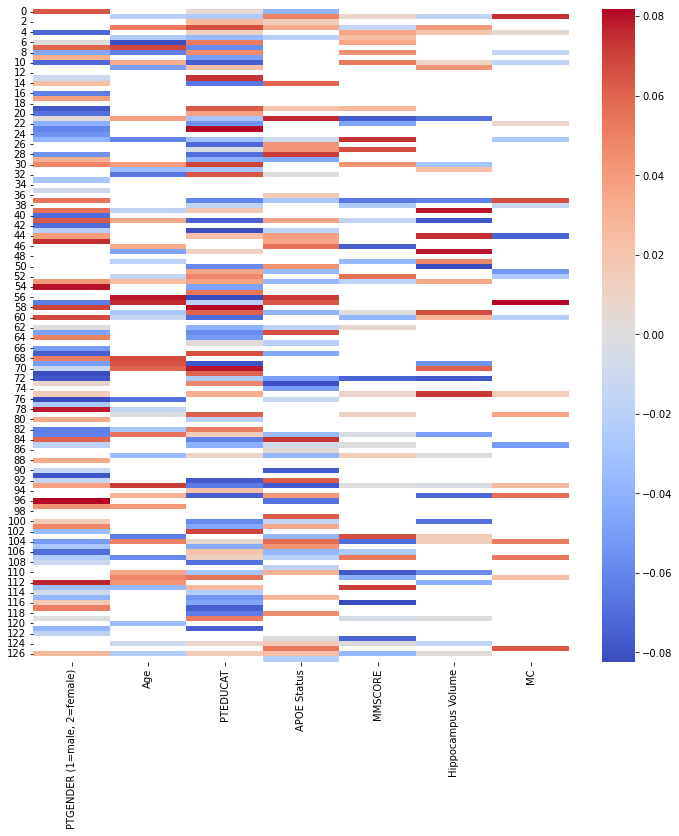

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
sns.heatmap(corr_table, cmap='coolwarm')


## PLS Regression

In [161]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [162]:
def optimise_pls_cv(X, y, n_comp):
    # Define PLS object
    pls = PLSRegression(n_components=n_comp)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)

    # Calculate scores
    r2 = r2_score(y, y_cv)
    mse = mean_squared_error(y, y_cv)
    rpd = y.std()/np.sqrt(mse)
    
    return (y_cv, r2, mse, rpd)

In [163]:
# Plot the mses
def plot_metrics(vals, ylabel, objective, title):
    with plt.style.context('ggplot'):
        plt.plot(xticks, np.array(vals), '-v', color='blue', mfc='blue')
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel)
        plt.title(title)
    plt.show()
    return idx

In [164]:
data_processor.demo_columns

['PTGENDER (1=male, 2=female)', 'Age', 'PTEDUCAT', 'APOE Status', 'MMSCORE']

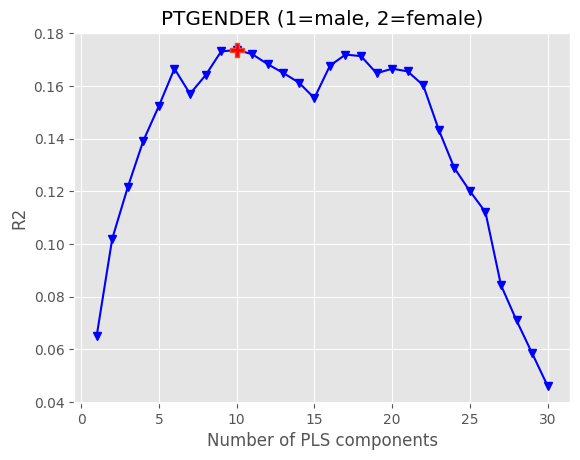

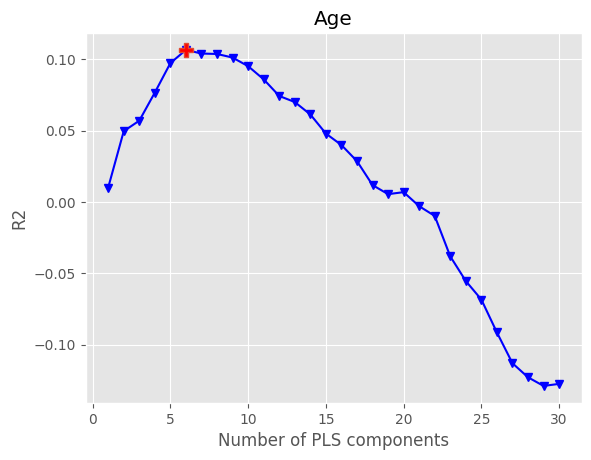

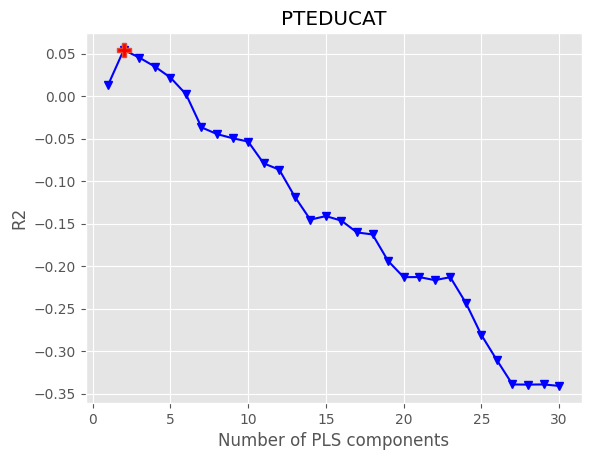

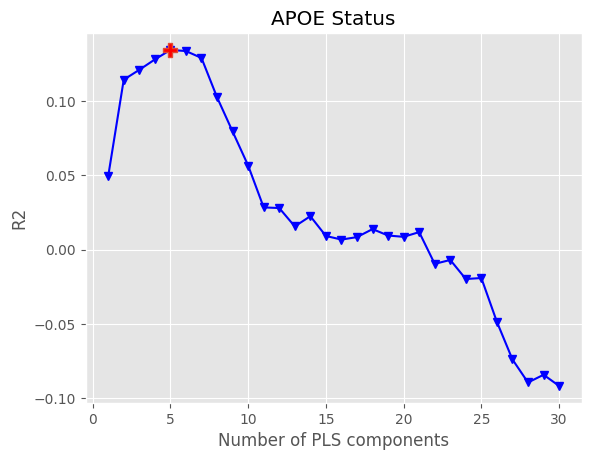

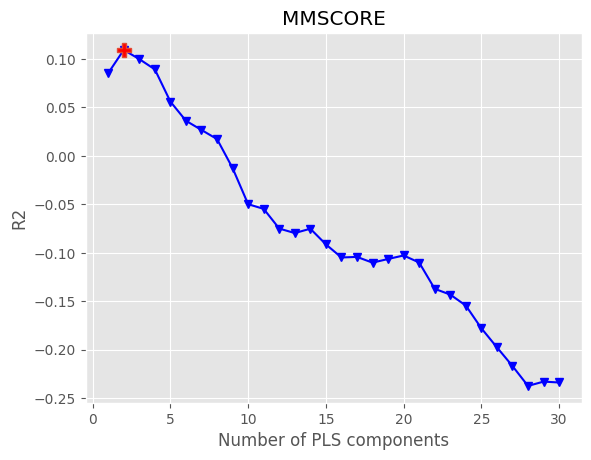

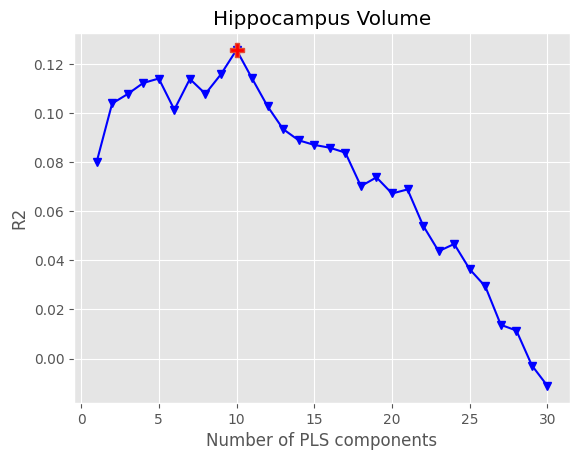

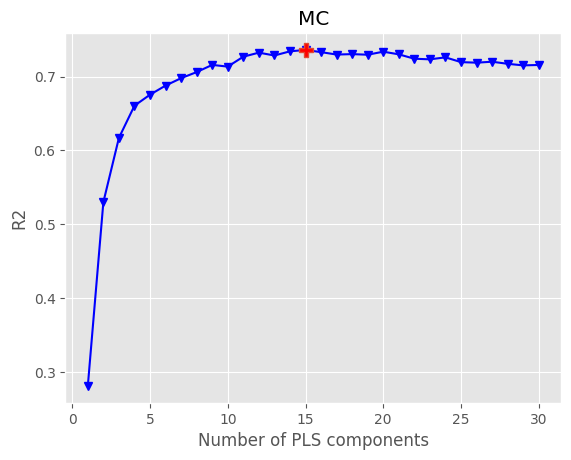

In [204]:
# 30 components - z (128)
xticks = np.arange(1, 31)
loadings = {}

for i, demo_column in enumerate(data_processor.demo_columns):
    
    r2s = []
    mses = []
    rpds = []

    for n_comp in xticks:
        y_cv, r2, mse, rpd = optimise_pls_cv(train['z'], train['demo'][:, i], n_comp)
        r2s.append(r2)
        mses.append(mse)
        rpds.append(rpd)
    
    best_idx = plot_metrics(r2s, 'R2', 'max', demo_column)
    best_n_comp = xticks[best_idx]
    
    pls = PLSRegression(n_components=best_n_comp)
    pls.fit(train['z'], train['demo'][:, i])
    loading = pls.x_loadings_[:, 0]
    loadings[demo_column] = loading
    
for target_name, target in zip(['Hippocampus Volume', 'MC'], [train['hippocampus'], train['mc']]):
    
    r2s = []
    mses = []
    rpds = []

    for n_comp in xticks:
        y_cv, r2, mse, rpd = optimise_pls_cv(train['z'], target, n_comp)
        r2s.append(r2)
        mses.append(mse)
        rpds.append(rpd)
    
    best_idx = plot_metrics(r2s, 'R2', 'max', target_name)
    best_n_comp = xticks[best_idx]
    
    pls = PLSRegression(n_components=best_n_comp)
    pls.fit(train['z'], target)
    loading = pls.x_loadings_[:, 0]
    loadings[target_name] = loading

In [205]:
loadings = pd.DataFrame.from_dict(loadings)

<AxesSubplot:>

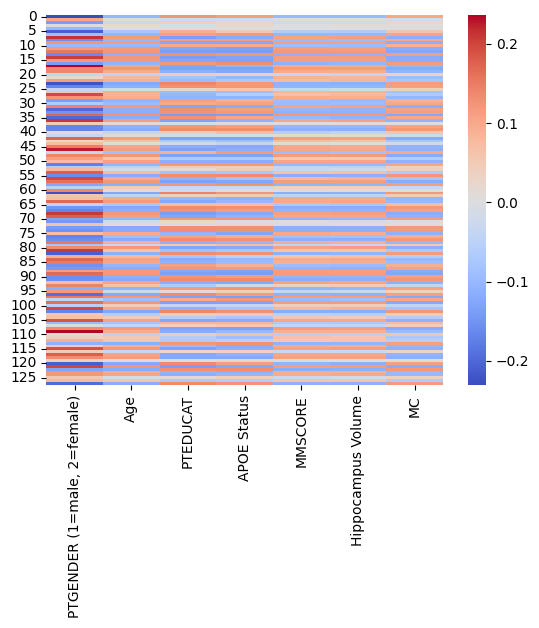

In [206]:
sns.heatmap(loadings, cmap='coolwarm')

<AxesSubplot:>

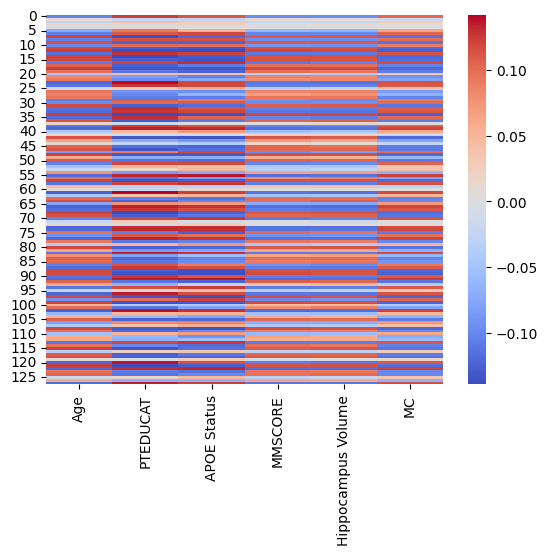

In [207]:
sns.heatmap(loadings.iloc[:, 1:], cmap='coolwarm')

<AxesSubplot:>

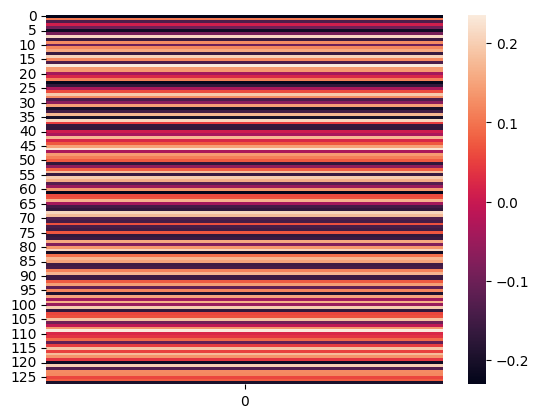

In [184]:
sns.heatmap(loadings.reshape(-1, 1))

# Fine-Tuned Encoder

In [153]:
#######################
config = edict()
config.server = server
config.gpus = gpus
local_rank = 0

config.finetune_file = os.path.join(f'../checkpoints/pet-supmoco/resnet/{hash[0]}/finetune/{hash[1]}/ckpt.last.pth.tar')
finetune_config = os.path.join(f'../checkpoints/pet-supmoco/resnet/{hash[0]}/finetune/{hash[1]}/configs.json')
with open(finetune_config, 'rb') as fb:
    finetune_config = json.load(fb)

finetune_config_names = [
    # data_parser
    'data_type', 'root', 'data_info', 'mci_only', 'n_splits', 'n_cv',
    'image_size', 'small_kernel', 'random_state',
    'intensity', 'crop', 'crop_size', 'rotate', 'flip', 'affine', 'blur', 'blur_std', 'prob',
    # model_parser
    'backbone_type', 'init_features', 'growth_rate', 'block_config', 'bn_size', 'dropout_rate',
    'arch', 'no_max_pool',
    # train
    'batch_size',
    # moco / supmoco
    'alphas',
    # others
    'task', 'projector_dim'
]

for name in finetune_config_names:
    if name in finetune_config.keys():
        setattr(config, name, finetune_config[name])

#########################################
set_gpu(config)
np.random.seed(config.random_state)
torch.manual_seed(config.random_state)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.allow_tf32 = True
torch.cuda.set_device(local_rank)

# Networks
if config.backbone_type == 'densenet':
    backbone = DenseNetBackbone(in_channels=1,
                                init_features=config.init_features,
                                growth_rate=config.growth_rate,
                                block_config=config.block_config,
                                bn_size=config.bn_size,
                                dropout_rate=config.dropout_rate,
                                semi=False)
    activation = True
elif config.backbone_type == 'resnet':
    backbone = build_resnet_backbone(arch=config.arch,
                                     no_max_pool=config.no_max_pool,
                                     in_channels=1,
                                     semi=False)
    activation = False
else:
    raise NotImplementedError

if config.small_kernel:
    backbone._fix_first_conv()

if config.crop:
    out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.crop_size)
else:
    out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.image_size)
classifier = LinearClassifier(in_channels=out_dim, num_classes=2, activation=activation)

backbone.load_weights_from_checkpoint(path=config.finetune_file, key='backbone')
classifier.load_weights_from_checkpoint(path=config.finetune_file, key='classifier')

# load finetune data
data_processor = BrainProcessor(root=config.root,
                                data_info=config.data_info,
                                data_type=config.data_type,
                                mci_only=config.mci_only,
                                random_state=config.random_state)
datasets = data_processor.process(n_splits=config.n_splits, n_cv=config.n_cv)

# intensity normalization
assert config.intensity in [None, 'scale', 'minmax']
mean_std, min_max = (None, None), (None, None)
if config.intensity is None:
    pass
elif config.intensity == 'scale':
    pass
elif config.intensity == 'minmax':
    with open(os.path.join(config.root, 'labels/minmax.pkl'), 'rb') as fb:
        minmax_stats = pickle.load(fb)
        min_max = (minmax_stats[config.data_type]['min'], minmax_stats[config.data_type]['max'])
else:
    raise NotImplementedError

train_transform, test_transform = make_transforms(image_size=config.image_size,
                                                  intensity=config.intensity,
                                                  min_max=min_max,
                                                  crop_size=config.crop_size,
                                                  rotate=config.rotate,
                                                  flip=config.flip,
                                                  affine=config.affine,
                                                  blur_std=config.blur_std,
                                                  prob=config.prob)

#########################################
train_set = Brain(dataset=datasets['train'], data_type=config.data_type, transform=test_transform)
test_set = Brain(dataset=datasets['test'], data_type=config.data_type, transform=test_transform)

train_loader = DataLoader(dataset=train_set, batch_size=16, drop_last=False)
test_loader = DataLoader(dataset=test_set, batch_size=16, drop_last=False)

###############
backbone.to(local_rank)
backbone.eval()

train_finetuned = {
    'h': [],
    'y': [],
    'demo': [],
    'hippocampus': [],
    'mc': []
}

test_finetuned = {
    'h': [],
    'y': [],
    'demo': [],
    'hippocampus': [],
    'mc': []
}

In [154]:
with torch.no_grad():
    
    for mode, dset, loader in zip(['train', 'test'], [train_set, test_set], [train_loader, test_loader]):
        
        for i, batch in enumerate(tqdm.tqdm(loader)):
    
            x = batch['x'].float().to(local_rank)
        
            h = backbone(x)
            h = nn.AdaptiveAvgPool3d(1)(h)
            h = torch.squeeze(h)

            if mode == 'train':
                train_finetuned['h'] += [h.detach().cpu().numpy()]
                train_finetuned['y'] += [batch['y'].detach().cpu().numpy()]
                train_finetuned['demo'] += [batch['demo'].detach().cpu().numpy()]
            else:
                test_finetuned['h'] += [h.detach().cpu().numpy()]
                test_finetuned['y'] += [batch['y'].detach().cpu().numpy()]
                test_finetuned['demo'] += [batch['demo'].detach().cpu().numpy()]

            #
            idx = batch['idx'].cpu().numpy()

            for i in idx:
                mri_id = dset.mri[i].split('/')[-1].replace('.pkl', '')
                pet_id = dset.pet[i].split('/')[-1].replace('.pkl', '')

                # hippocampus volume            
                temp = mri_table.iloc[np.where(mri_table_filenames == mri_id)[0].item(), :]
                volume = temp['Left-Hippocampus'] + temp['Right-Hippocampus']

                # NC
                temp = mc_table.iloc[np.where(mc_table['ID'] == pet_id)[0].item(), :]
                mc = temp['MC']
                mc = 53.6 * mc - 43.2

                if mode == 'train':
                    train_finetuned['hippocampus'].append(volume)
                    train_finetuned['mc'].append(mc)
                else:
                    test_finetuned['hippocampus'].append(volume)
                    test_finetuned['mc'].append(mc)

backbone.to('cpu')
print('features are extracted')


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.18s/it]

features are extracted


In [155]:
for k, v in train_finetuned.items():
    try:
        train_finetuned[k] = np.concatenate(v)
    except:
        train_finetuned[k] = np.array(v)
        
for k, v in test_finetuned.items():
    try:
        test_finetuned[k] = np.concatenate(v)
    except:
        test_finetuned[k] = np.array(v)

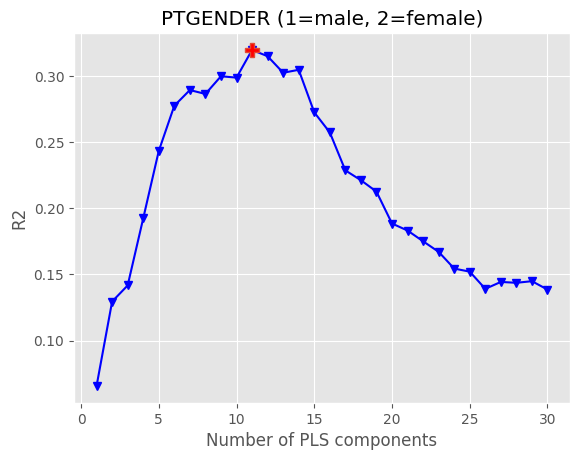

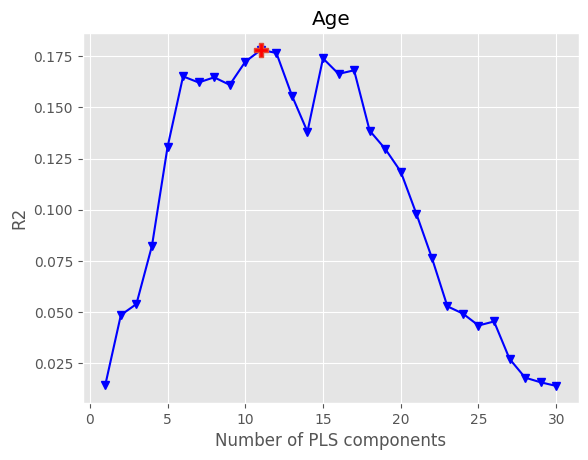

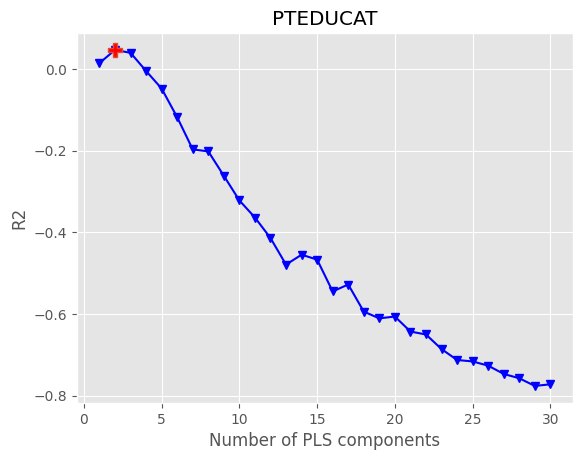

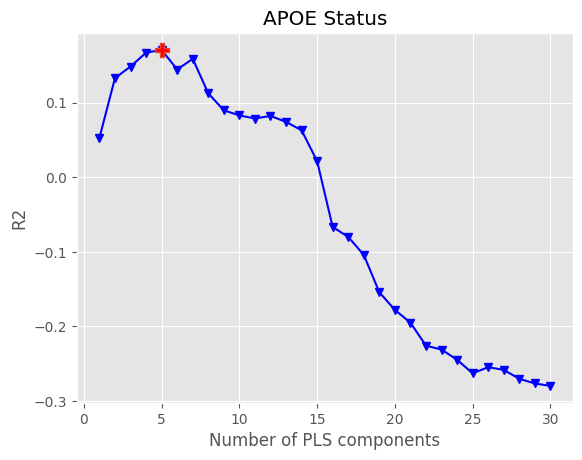

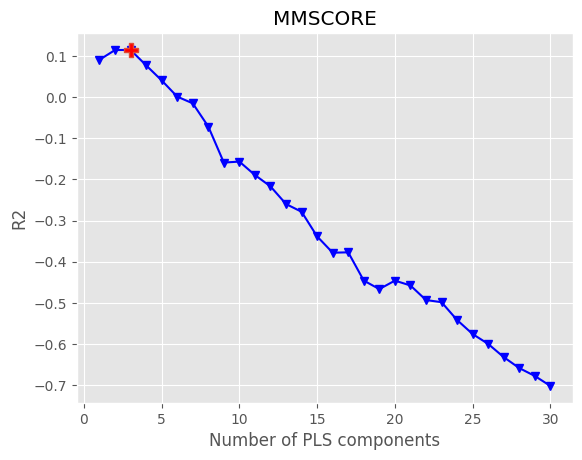

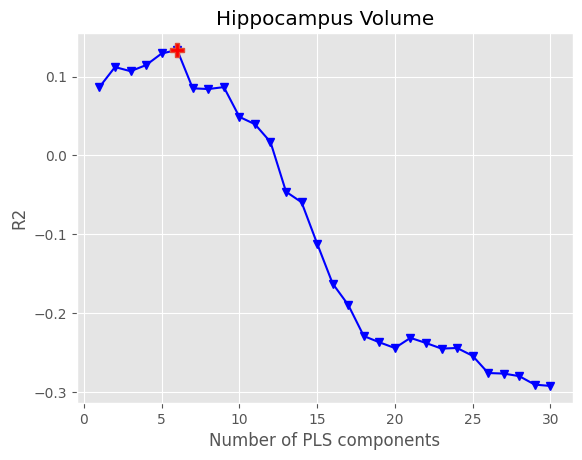

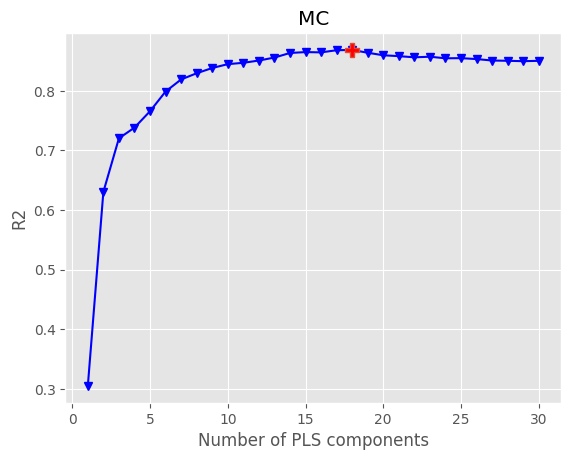

In [156]:
# 30 components - h (2048)
xticks = np.arange(1, 31)

for i, demo_column in enumerate(data_processor.demo_columns):
    
    r2s = []
    mses = []
    rpds = []

    for n_comp in xticks:
        y_cv, r2, mse, rpd = optimise_pls_cv(train_finetuned['h'], train_finetuned['demo'][:, i], n_comp)
        r2s.append(r2)
        mses.append(mse)
        rpds.append(rpd)
    plot_metrics(r2s, 'R2', 'max', demo_column)
    
for target_name, target in zip(['Hippocampus Volume', 'MC'], [train_finetuned['hippocampus'], train_finetuned['mc']]):
    
    r2s = []
    mses = []
    rpds = []

    for n_comp in xticks:
        y_cv, r2, mse, rpd = optimise_pls_cv(train_finetuned['h'], target, n_comp)
        r2s.append(r2)
        mses.append(mse)
        rpds.append(rpd)
    plot_metrics(r2s, 'R2', 'max', target_name)

In [ ]:
data_processor.demo_columns

In [ ]:
Z = Z.detach().cpu().numpy()
Y = Y.detach().cpu().numpy()
demo = demo.detach().cpu().numpy()

# 1. UMAP

In [ ]:
import umap.umap_ as umap

In [ ]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.2)
embedding = reducer.fit_transform(Z)
classes = [-1, 0, 1]
colors = ['grey', 'blue', 'red']
plt.figure(figsize=(8, 8))
for c, color in zip(classes, colors):
    plt.scatter(embedding[Y==c, 0], embedding[Y==c, 1], s=6, color=colors[c+1])
plt.show()

# load amyloid info

In [ ]:
import pandas as pd
amyloid_info = pd.read_excel('/raidWorkspace/mingu/Data/ADNI/labels/AV45_FBP_SUVR.xlsx', sheet_name='list_id_SUVR_RSF', engine='openpyxl')
amyloid_info = amyloid_info[['ID', 'AmyloidPositive_CL20', 'AmyloidPositive_CL37']]

In [ ]:
left_idx = np.where(embedding[:, 0] < 6.0)[0]
right_idx = np.where(embedding[:, 0] > 6.0)[0]
len(left_idx) + len(right_idx) == len(total_set)

In [ ]:
left_id = np.array(total_set.pet)[left_idx]
left_id = [i.split('/')[-1].replace('.pkl', '') for i in left_id]
left_y = np.array(total_set.y)[left_idx]

right_id = np.array(total_set.pet)[right_idx]
right_id = [i.split('/')[-1].replace('.pkl', '') for i in right_id]
right_y = np.array(total_set.y)[right_idx]

In [ ]:
left_cl20 = [amyloid_info.loc[amyloid_info.ID == a, 'AmyloidPositive_CL20'].item() for a in left_id]
left_cl37 = [amyloid_info.loc[amyloid_info.ID == a, 'AmyloidPositive_CL37'].item() for a in left_id]

right_cl20 = [amyloid_info.loc[amyloid_info.ID == a, 'AmyloidPositive_CL20'].item() for a in right_id]
right_cl37 = [amyloid_info.loc[amyloid_info.ID == a, 'AmyloidPositive_CL37'].item() for a in right_id]

In [ ]:
left_df = pd.DataFrame({'label': left_y, 'cl20': left_cl20, 'cl37': left_cl37})
right_df = pd.DataFrame({'label': right_y, 'cl20': right_cl20, 'cl37': right_cl37})

In [ ]:
pd.pivot_table(left_df, values='cl20', index='label', columns=['cl20'], aggfunc='count')

In [ ]:
pd.pivot_table(right_df, values='cl20', index='label', columns=['cl20'], aggfunc='count')

In [ ]:
pd.pivot_table(left_df, values='cl37', index='label', columns=['cl37'], aggfunc='count')

In [ ]:
pd.pivot_table(right_df, values='cl37', index='label', columns=['cl37'], aggfunc='count')

# Demo

In [ ]:
demo_info = pd.read_excel('/raidWorkspace/mingu/Data/ADNI/labels/AV45_FBP_SUVR.xlsx', sheet_name='demographic info', engine='openpyxl')
demo_info = demo_info[['ID1', 'RID', 'Age', 'VISCODE2']]

In [ ]:
left_rid = [demo_info.loc[demo_info.ID1 == a, 'RID'].item() for a in left_id]
left_age = [demo_info.loc[demo_info.ID1 == a, 'Age'].item() for a in left_id]
left_vc = [demo_info.loc[demo_info.ID1 == a, 'VISCODE2'].item() for a in left_id]

right_rid = [demo_info.loc[demo_info.ID1 == a, 'RID'].item() for a in right_id]
right_age = [demo_info.loc[demo_info.ID1 == a, 'Age'].item() for a in right_id]
right_vc = [demo_info.loc[demo_info.ID1 == a, 'VISCODE2'].item() for a in right_id]

In [ ]:
left_df = pd.DataFrame({'label': left_y, 'age': left_age, 'vc': left_vc})
right_df = pd.DataFrame({'label': right_y, 'age': right_age, 'vc': right_vc})

In [ ]:
pd.pivot_table(left_df, values='age', index='label', aggfunc=np.mean)

In [ ]:
pd.pivot_table(right_df, values='age', index='label', aggfunc=np.mean)

In [ ]:
left_df['cluster'] = 'Cluster A'
right_df['cluster'] = 'Cluster B'

In [ ]:
df = pd.concat([left_df, right_df]).reset_index(drop=True)
df = df.loc[df.label != -1].reset_index(drop=True)

In [ ]:
df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(8, 8))
sns.boxplot(x="label", y="age", palette=["m", "g"], hue='cluster',
            data=df)
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
sns.boxplot(x="cluster", y="age", palette=["m", "g"],
            data=df)
plt.show()

In [ ]:
from scipy import stats

In [ ]:
for label in [0, 1]:
    a = temp.loc[temp.cluster == 'Cluster A']['age'].values
    b = temp.loc[temp.cluster == 'Cluster B']['age'].values
    
    tstat, pval = stats.ttest_ind(a, b, alternative='less', equal_var=False)
    print(pval)

# 2. TSNE

In [ ]:
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding

In [ ]:
tsne = TSNE(n_components=2, perplexity=30.0, learning_rate=200.0, n_iter=2000, metric='euclidean', init='pca')

In [ ]:
embedding = tsne.fit_transform(Z)
classes = [-1, 0, 1]
colors = ['grey', 'blue', 'red']
plt.figure(figsize=(8, 8))
for c, color in zip(classes, colors):
    plt.scatter(embedding[Y==c, 0], embedding[Y==c, 1], s=6, color=colors[c+1])
plt.title('TSNE')
plt.show()

In [ ]:
isomap = Isomap(n_neighbors=10, n_components=2)

In [ ]:
embedding = isomap.fit_transform(Z)
classes = [-1, 0, 1]
colors = ['grey', 'blue', 'red']
plt.figure(figsize=(8, 8))
for c, color in zip(classes, colors):
    plt.scatter(embedding[Y==c, 0], embedding[Y==c, 1], s=6, color=colors[c+1])
plt.title('ISOMAP')
plt.show()

In [ ]:
lle = LocallyLinearEmbedding(n_neighbors=15, n_components=2)

In [ ]:
embedding = lle.fit_transform(Z)
classes = [-1, 0, 1]
colors = ['grey', 'blue', 'red']
plt.figure(figsize=(8, 8))
for c, color in zip(classes, colors):
    plt.scatter(embedding[Y==c, 0], embedding[Y==c, 1], s=6, color=colors[c+1])
plt.title('Locally Linear Embedding')
plt.show()